In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

import torch
from torch import nn

from utils import get_gaussian_targets, gaussian
from models import RNN
from train import test_and_get_stats, pre_train, train_force, train_bptt_sparse, train_bptt
from viz import plot_learning

In [2]:
# set meta-parameters
# for plotting style
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)
# for pytorch tensors
device = 'cpu'
# for reproducibility while troubleshooting; numpy is for model sparse conns
torch.random.manual_seed(93214)
np.random.seed(35107)

Test loss: 0.362373


/home/ryan/time_coding/train.py:238: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


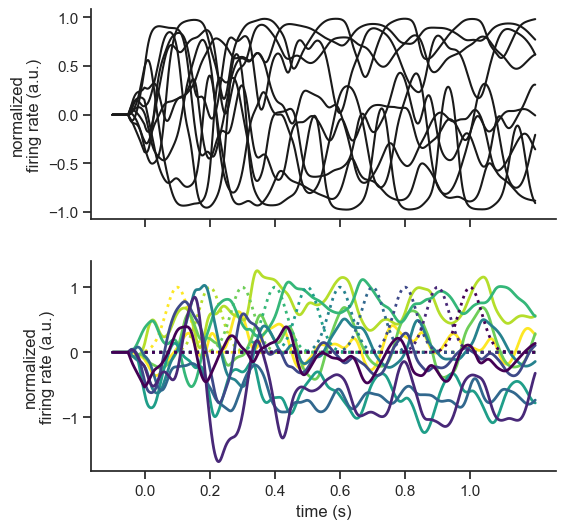

In [3]:
# instantiate model, loss function, and optimizer
include_stp = False
n_inputs, n_hidden, n_outputs = 1, 300, 10
model = RNN(n_inputs=n_inputs, n_hidden=n_hidden,
            n_outputs=n_outputs, include_stp=include_stp)
model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# set parameters
# simulation parameters
dt = 1e-3  # 1 ms
tstop = 1.2  # 1 sec
times = np.arange(-0.1 + dt, tstop + dt, dt)
n_times = len(times)

# define inputs (for contextual modulation / recurrent perturbations)
n_batches = 1
inputs = torch.zeros((n_batches, n_times, n_inputs))
perturb_dur = 0.05  # 50 ms
perturb_win_mask = np.logical_and(times > -perturb_dur, times < 0)
inputs[:, perturb_win_mask, :] = 1.0

# define output targets
# set std s.t. amplitude decays to 1/e at intersection with next target
targ_std = 0.05 / np.sqrt(2)  # ~35 ms
# tile center of target delays spanning sim duration (minus margins)
delay_times = np.linspace(0.1, 1.0, n_outputs)
targets = get_gaussian_targets(n_batches, delay_times, times, targ_std)

# set initial conditions of recurrent units fixed across iterations of
# training and testing
# h_0 = torch.rand(n_hidden) * 2 - 1  # uniform in (-1, 1)
h_0 = torch.zeros(n_hidden)
h_0 = torch.tile(h_0, (n_batches, 1))  # replicate for each batch
# r_0 = torch.rand(n_hidden)
# r_0 = torch.rand(n_hidden) * model.p_rel.detach()  # uniform in (0, p_rel)
# r_0 = model.p_rel.detach() / (1 + model.beta * 0.5 * model.tau_depr)  # uniform in (0, p_rel)
# r_0 = model.p_rel.detach()
r_0 = torch.ones(n_hidden)
r_0 = torch.tile(r_0, (n_batches, 1))
# u_0 = torch.rand(n_hidden) # uniform in (0, 1)
u_0 = model.p_rel.detach()
u_0 = torch.tile(u_0, (n_batches, 1))

# run opt routine
# move to desired device
inputs = inputs.to(device)
targets = targets.to(device)
h_0 = h_0.to(device)
r_0 = r_0.to(device)
# r_0 = None
u_0 = u_0.to(device)
# u_0 = None

# plot model output before training
hidden_sr, output_sr, stats_0 = test_and_get_stats(inputs, targets, times,
                                                   model, loss_fn, h_0, r_0,
                                                   u_0, plot=True)

# pre-train
# max_iter_pretrain = 10
# for iter_idx in range(max_iter_pretrain):
#     _ = pre_train(inputs, times, model, h_0)

# # train model weights
# max_iter = 500
# convergence_reached = False
# loss_per_iter = list()
# for iter_idx in range(max_iter):
#     print(f"Iteration {iter_idx + 1}")
#     # loss, param_dist = train_force(inputs, targets, times, model, loss_fn,
#     #                                optimizer, h_0, r_0, u_0,
#     #                                presyn_idx=iter_idx)
#     # loss, param_dist = train_bptt_sparse(inputs, targets, times, model,
#     #                                      loss_fn, optimizer, h_0, r_0, u_0,
#     #                                      p_backprop=0.2)
#     loss = train_bptt(inputs, targets, times, model, loss_fn, optimizer,
#                       h_0, r_0, u_0)
#     loss_per_iter.append(loss)
#     if len(loss_per_iter) >= 10:
#         mean_diff = np.diff(loss_per_iter[-10:]).mean()
#         if np.abs(mean_diff) < 1e-6:
#             convergence_reached = True
#             break

# # print(f"Trial {sample_idx} training complete!!")
# if not convergence_reached:
#     print(f"Warning: didn't converge!!!")

# # plot loss across training
# fig_learning = plot_learning([stats_0['loss']] + loss_per_iter, max_iter=None)
# # plt.savefig('/home/ryan/Desktop/training_loss_force.png')

# # investigate fitted model
# # plot model output after training
# hidden_sr, output_sr, stats_1 = test_and_get_stats(inputs, targets, times,
#                                                    model, loss_fn, h_0, r_0,
#                                                    u_0, plot=True)

In [4]:
stats_0['dimensionality']

7.818979576142951

In [11]:
stats_1['dimensionality']

5.535802238537766

In [4]:
from cycler import cycler
from matplotlib.patches import Rectangle

def plot_state_traj(h_units, syn_eff, outputs, targets, times):
    # NB: assumes a single batch/trial
    n_times, n_hidden = h_units.shape
    n_outputs = outputs.shape[1]

    time_mask = times > 0
    times_after_zero = times[time_mask]

    n_hidden_plot = 30  # number of hidden units to plot
    if n_hidden < 5:
        n_hidden_plot = n_hidden

    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

    # recurrent unit trajectories
    cm_hidden = sns.color_palette('colorblind')
    axes[0].set_prop_cycle(cycler('color', cm_hidden))
    axes[0].plot(times, h_units[:, :n_hidden_plot])
    axes[0].add_patch(Rectangle([-0.05, -1], 0.05, 2.0, ec='none', fc='k',
                                alpha=0.2, zorder=100))
    axes[0].set_ylabel('normalized\nfiring rate (a.u.)')
    axes[0].set_yticks([-1, 0, 1])

    # synaptic utilization (from STP)
    axes[1].set_prop_cycle(cycler('color', cm_hidden))
    axes[1].plot(times, syn_eff[:, :n_hidden_plot])
    axes[1].add_patch(Rectangle([-0.05, 0], 0.05, 1.0, ec='none', fc='k',
                                alpha=0.2, zorder=100))
    axes[1].set_ylabel('synaptic\nefficacy')
    axes[1].set_yticks([0, 1])

    # outputs
    cm_output = plt.cm.viridis_r(np.linspace(0, 1, n_outputs))
    axes[2].set_prop_cycle(cycler('color', cm_output))
    axes[2].plot(times_after_zero, targets[time_mask, :], lw=2, ls=':')
    axes[2].plot(times, outputs, lw=2)
    axes[2].add_patch(Rectangle([-0.05, -1], 0.05, 2.0, ec='none', fc='k',
                                alpha=0.2, zorder=100))
    axes[2].set_xticks(np.arange(0, 1.2, 0.2))
    axes[2].set_xlabel('time (s)')
    axes[2].set_ylabel('normalized\nfiring rate (a.u.)')
    axes[2].set_yticks([-1, 0, 1])

    fig.tight_layout()

    return fig


def plot_all_units(h_units, syn_eff, outputs, targets, times):
    # NB: assumes a single batch/trial
    n_times, n_hidden = h_units.shape
    n_outputs = outputs.shape[1]

    time_mask = times > 0
    times_after_zero = times[time_mask]

    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(8, 2.5))

    # recurrent unit trajectories
    cm_hidden = sns.color_palette('colorblind')
    hid_res_map = axes[0].pcolormesh(times, range(1, n_hidden + 1),
                                     h_units.T, cmap='RdGy',
                                     vmin=-1, vmax=1)
    axes[0].set_title('hidden unit\nresponses')
    axes[0].set_ylabel('unit #')
    axes[0].set_yticks([1, n_hidden])
    cbar_0 = fig.colorbar(hid_res_map, ax=axes[0], ticks=[-1, 0, 1])

    # synaptic efficacy (from STP)
    syn_eff_map = axes[1].pcolormesh(times, range(1, n_hidden + 1),
                                     syn_eff.T, cmap='Greys',
                                     vmin=0, vmax=1)
    axes[1].set_title('synaptic\nefficacy')
    axes[1].set_yticks([1, n_hidden])
    axes[1].set_xlabel('time (s)')
    cbar_1 = fig.colorbar(syn_eff_map, ax=axes[1], ticks=[0, 1])

    # outputs
    colors_output = plt.cm.viridis_r(np.linspace(0, 1, n_outputs))
    out_res_map = axes[2].pcolormesh(times_after_zero,
                                     range(1, n_outputs + 1),
                                     outputs[time_mask, :].T, cmap='RdGy',
                                     vmin=-1, vmax=1)
    peak_idxs = targets.argmax(dim=0)
    peak_times = times[peak_idxs]
    axes[2].scatter(peak_times, range(1, n_outputs + 1), marker='|',
                    c=colors_output, s=80, linewidths=3)
    axes[2].set_title('output unit\nresponses')
    axes[2].set_yticks([1, n_outputs])
    axes[2].set_xticks([0, 1])
    # axes[2].set_ylabel('normalized\nfiring rate (a.u.)')
    cbar_2 = fig.colorbar(out_res_map, ax=axes[2], ticks=[-1, 0, 1])

    fig.tight_layout()

    return fig


def plot_weight_distr(W_hh, W_hh_mask, syn_eff, eff_gain, true_gain):
    fig, axes = plt.subplots(1, 1, figsize=(3, 3))
    n_times, n_hidden = syn_eff.shape
    n_weights = W_hh_mask.sum()
    postsyn_weights = true_gain * W_hh[W_hh_mask == 1]
    effective_weights = torch.stack([(syn_eff[t_idx, :] * true_gain * W_hh * W_hh_mask)[W_hh_mask == 1] for t_idx in range(n_times)])
    effective_weights_avg = effective_weights.mean(dim=0)
    # print(effective_weights_avg)
    weight_bins = np.linspace(-4, 4, 30)
    # normalize to produce PMF
    weights = torch.ones_like(postsyn_weights) / n_weights
    axes.hist(postsyn_weights, bins=weight_bins, weights=weights, alpha=0.7,
              label='static')
    pdf, _, _ = axes.hist(effective_weights_avg, bins=weight_bins,
                          weights=weights, alpha=0.7,
                          label='effective (simulated)')
    # print(np.sum(pdf))

    prob_c = float(torch.count_nonzero(model.W_hh_mask) /
                   torch.numel(model.W_hh_mask))
    w_hidden_std = eff_gain / np.sqrt(prob_c * n_hidden)
    theoretic_distr = gaussian(weight_bins, 0, w_hidden_std)
    theoretic_distr /= np.sum(theoretic_distr)  # normalize
    # print(np.sum(theoretic_distr))

    axes.plot(weight_bins, theoretic_distr, 'k:', lw=2,
              label=f'effective (theoretical)')
    axes.set_xlabel('synaptic weight')
    axes.set_ylabel('probability')

    axes.legend()

    fig.tight_layout()

    return fig

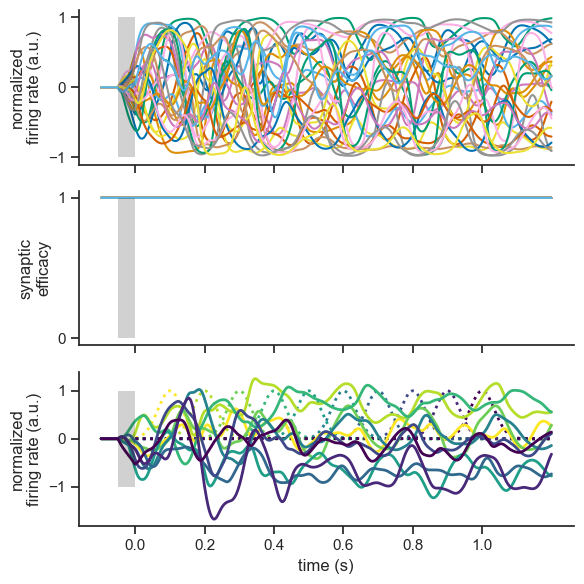

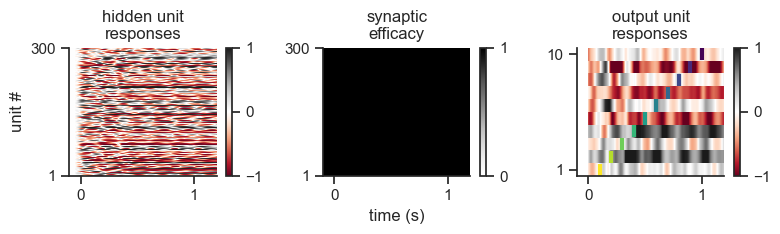

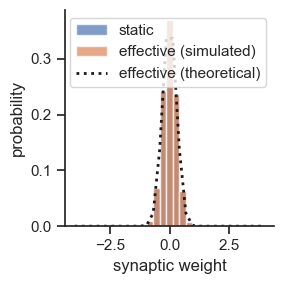

In [5]:
dt = times[1] - times[0]
model.eval()

with torch.no_grad():

    # Compute prediction error
    h_t, r_t, u_t, z_t, dhdh_t = model(inputs, h_0=h_0, r_0=r_0, u_0=u_0, dt=dt, return_dhdh=True)
    loss = loss_fn(z_t[:, times > 0, :], targets[:, times > 0, :])

weights = model.W_hh * model.presyn_scaling.detach()

# select first batch if more than one exists
hidden_batch = torch.tanh(h_t).cpu()[0]
syn_eff_batch = r_t.cpu()[0] * u_t.cpu()[0]
outputs_batch = z_t.cpu()[0]
targets_batch = targets.cpu()[0]

fig_traj = plot_state_traj(h_units=hidden_batch, outputs=outputs_batch,
                           syn_eff=syn_eff_batch,
                           targets=targets_batch, times=times)

fig_all_units = plot_all_units(h_units=hidden_batch, syn_eff=syn_eff_batch,
                               outputs=outputs_batch,
                               targets=targets_batch, times=times)

fig_weights_distr = plot_weight_distr(weights, model.W_hh_mask,
                                      syn_eff_batch,
                                      eff_gain=model.effective_gain,
                                      true_gain=model.gain)
plt.show()

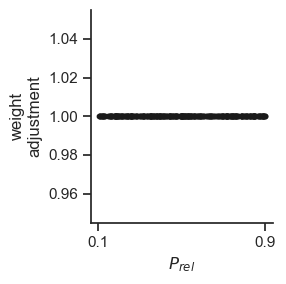

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
# sort_idxs = np.argsort(model.p_rel.detach().numpy())
p_rel = model.p_rel.detach().numpy()
post_syn_adjustment = model.presyn_scaling.detach().numpy()
axes.scatter(p_rel, post_syn_adjustment, s=10, c='k')
axes.set_xticks([0.1, 0.9])
axes.set_xlabel('$P_{rel}$')

# axes.set_yticks([0, np.max(post_syn_adjustment).round(decimals=1)])
axes.set_ylabel('weight\nadjustment')
fig.tight_layout()

In [ ]:
dhdh_t_batch = dhdh_t[0].cpu()
dh

(array([  49,   50,   51, ..., 1197, 1198, 1199]),)

In [8]:
dhdh_t[0, -1, :]

tensor([  0.9232,   1.0039,   1.2146,   1.3067,   0.9179,   1.0058,   1.0219,
          1.0163,   1.0436,   1.0001,   0.9882,   1.1612,   0.9773,   0.9267,
          0.8346,   1.1503,   0.9197,   0.9877,   0.9204,   0.9194,   0.9452,
          1.0295,   0.9818,   0.8892,   1.0304,   0.7978,   0.9148,   1.0383,
          1.0854,   1.0169,   0.7829,   1.0479,   0.9629,   0.9584,   0.9868,
          1.1023,   1.0036,   0.9416,   0.9267,   1.0120,   1.0309,   0.9113,
          0.8620,   0.9551,   1.1825,   0.9548,   0.8753,   1.0712,   0.8548,
          0.9585,   2.1194,   0.9243,   1.0159,  10.2229,   0.9236,   0.8809,
          0.8873,   1.0230,   1.3648,   0.9888,   0.9411,   1.0019,   1.2520,
          1.1657,   1.0497,   0.9282,   0.8071,   1.1096,   1.0269,   1.7131,
          1.0088,   0.5928,   0.2820,   0.9902,   0.8446,   1.0481,   0.9247,
          1.0056,   0.8987,   1.1063,   0.8528,   0.8027,   0.9392,   0.9946,
          0.7353,   0.9762,   1.0957,   0.9989,   1.4460,   1.16

In [ ]:
fig_traj.savefig('/home/ryan/Desktop/traj_gain_scaled_hz_nonforce_postlearning.png')
fig_all_units.savefig('/home/ryan/Desktop/units_all_gain_scaled_hz_nonforce_postlearning.png')
fig_weights_distr.savefig('/home/ryan/Desktop/hidden_weights_gain_scaling_postlearning.png')